# John Vincent Deniega
# ADS 509 - Fall 2024
# 1 October 2024

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [2]:
# add any additional libaries you need here
import nltk
import warnings

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
#nltk.download('brown')
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

(166, 3)

### Investigate the dataframe for format and structure

In [6]:
df.head()

,category,id,text
0,editorial,cb01,Assembly session brought much good The General...
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra..."
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...
4,editorial,cb05,Help when needed If the Dominican Republic ach...


In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/Users/johnvincent/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='category'>

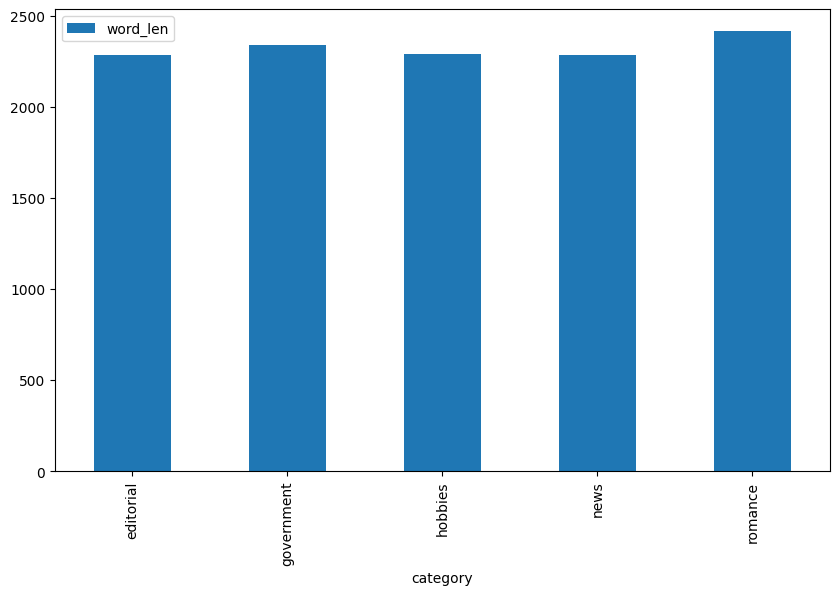

In [8]:
%matplotlib inline
warnings.filterwarnings('ignore', category=DeprecationWarning) # For notebook clarity
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

### Reference: 

SciKit-Learn. (n.d.). CountVectorizer. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

SciKit-Learn. (n.d.). TfidfVectorizer. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The data frame 'count_text_vectors' contains the output of the CountVectorizer in the form of a matrix where each row corresponds to a given document's data in df['text'] and each column corresponds to a unique word set contained within the corpus. The values mapped to each row and column would then be populated with a count of how many times that particular token appears.

The data fram 'tfidf_text_vectors' contains the output of the TfidfVectorizer in the form of a matrix where each row corresponds to a document and each column correponds to a word, similar to the count_text_vectors matrix. The value that is mapped to each row and column is the calculated TF-IDF score for that particular word instead of the simple count provided from the previous matrix.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

### Reference

SciKit-Learn. (n.d.). NMF. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


### Percentage of each topic comprising corpus

In [13]:
# Your code here
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0 # From BTAP Ch. 8 Notebook

array([18.20216354, 25.88744413, 29.5696224 , 14.29955027, 12.04121966])

### Reference
Pandas. (n.d.). pandas.crosstab. Pydata. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

### Output Tallies on NMF

In [14]:
df['predicted_topic'] = np.argmax(W_text_matrix, axis=1)
topic_cat_tally = pd.crosstab(df['predicted_topic'], df['category'])
topic_cat_tally

category,editorial,government,hobbies,news,romance
predicted_topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: There appears to be a moderately strong association between topic 0 and the editorial category at 20 out of 32. Topic 1 is strongly associated with the romance category at 29 out of 41. Topic 2 is ambiguous with 26 documents being assigned to government and hobbies each with other following categories. Topic 3 is very strongly associated with news at 17 of 18 documents predicted. Finally, topic 4 is strongly associated with news, however the document size is relatively small at 10 total documents, so associations for this topic would require a greater error or misclassification tolerance.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


### Reference

Albrecht, J., Ramachandran, S., & Winkler, C. (n.d.). Chapter 8: Unsupervised methods: Topic modeling and clustering. Github. https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

In [15]:
# Your code here
# This code references from the example in Albrecht et al. (n.d.) Chapter 8 Notebook
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [16]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


In [17]:
svd_text_model.singular_values_ # Third step from Albrecht et al.

array([3.70145447, 2.25514739, 1.69705678, 1.66202287, 1.56023004])

### Output Tallies on TruncatedSVD

In [18]:
df['predicted_topic_svd'] = np.argmax(W_svd_text_matrix, axis=1)
svd_topic_cat_tally = pd.crosstab(df['predicted_topic_svd'], df['category'])
svd_topic_cat_tally

category,editorial,government,hobbies,news,romance
predicted_topic_svd,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: It appears that the TruncatedSVD only recognizes four categories from the corpus, with no documents being assigned to Topic 2. This can be due to the model associating documents more to Topics 0, 1, 3, and 4 than to Topic 2. With that said, Topic 0 appears to be the most ambiguous or overly broad to be useful in categorizing documents. Topic 1 is only associated with the romance category, meaning that tokens from Topic 1 appear to be highly indicative of romance relative to the other categories. The same can be said for Topic 3, however because there are only 3 documents, this a higher error tolerance is required to assert this association. Finally, topic 4 appears to have the most association with news. Further, topics 1, 3, and 4 with their singular categorization with the truncated SVD model suggest that for these topics there may be a high degree of specificity.

In [19]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Topic 0 appears to be formal topics or address given the use of 'mr', 'mrs', and 'state' listed as important features for this topic. This can be associated to Brown's "news" or "government" categories. Topic 1 appears to be informal conversation with contractions and words such as 'll', 'didn', and 'got'. This may be associated to "romance" or "hobbies" categories. Topic 2 looks to be political or historical in context given the words 'kennedy' and 'khruschev', so "government" seems to be an appropriate association. Topic 3 has the words 'club', 'game', and 'university' suggesting college sports as a topic, or even more broadly sports. All of Topic 4's top words appears to be specifically baseball related, which make cause some overlap. This does make sense, however that these two topics predominantly fall under the 'news' category in the original lists.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

### Reference

Albrecht, J., Ramachandran, S., & Winkler, C. (n.d.). Chapter 8: Unsupervised methods: Topic modeling and clustering. Github. https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

In [20]:
# Fit your LDA model here
# This code references from the example in Albrecht et al. (n.d.) Chapter 8 Notebook
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [21]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: Topic 0 appears to be particularly ambiguous with common words of no apparent commonality. The words in Topic 1 appear to be more government related. Topic 2 appears to be government or news related with "president", "city", and "state". Topic 3 appear to be news related, though the words are also somewhat general to apply to a variety of categories. Finally, Topic 4 appears to be strongly government-related, which is in line with the Brown category.

### Output Tallies for LDA

In [22]:
df['predicted_topic_lda'] = np.argmax(W_lda_text_matrix, axis=1)
lda_topic_cat_tally = pd.crosstab(df['predicted_topic_lda'], df['category'])
lda_topic_cat_tally

category,editorial,government,hobbies,news,romance
predicted_topic_lda,,,,,
0,3,1,11,4,28
1,1,12,9,3,0
2,21,3,2,32,1
3,2,4,8,3,0
4,0,10,6,2,0


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 tends to align with the romance category by a moderately strong association. Topic 1 appears to align strongest with the government category, however the hobbies category shares a somewhat similar association. Topic 2 shares a strong association with editoral and news categories, however it appears to be ambiguous when comparing between the two categories. Topic 3 shares a moderate association with the hobby category, however with the relatively low document count this association must be considered with a higher margin or error. Topic 4 shares a moderately strong association with the government topics, however, as with Topic 3 this association must be considered with a higher margin for error.

In [23]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [24]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Topics 2 and 4 appear to be the most similar given their spacing on the PC scatterplot, however none of the Topics appear to have any overlap, which is surprising given the number of relatively even classification given on some topics. Topic 3 appears to be the largest topic encompassing the most documents. Topics 2 and 5 appear to the most dissimilar from Topic 1 given their distance. From the salient terms graph, the probability of some words across topics does provide a general set of words, however when sliding the slider towards zero the distinctiveness of those words show a more immediate and significant indication of which Topic the document belongs do. This is expected as focusing on the distinct set of words inherently finds the most separate groups of words relative to the others within the corpus. Most significantly, Topic 1 appears to be the most general, which imply romance and hobbies. Topic 2 and 4 appear to be most associated with technology and industry. Topic 3 is particularly distinct on historical topics that are likely associated with the Cold War era. Finally, Topic 5 appears to generally have more distinct usage of financial and economic terms.
